# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Check number of rows and columns of df
df.shape

(45993, 3)

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
# Check number of rows and columns of df_content
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
# Check number of different article IDs in the dataset df
df["article_id"].nunique()

714

In [6]:
# Check number of different article titles in the dataset df --> should be the same as the number of article IDs
df["title"].nunique()

714

In [7]:
# Check number of different users (defined by the email adress) in the dataset
df["email"].nunique()

5148

In [8]:
# Check the number of articles each user interacts with
# Sort them in a descending order

art_user_interactions = df.groupby("email")["article_id"].count().sort_values(ascending=False)
art_user_interactions.head(5)

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

Text(0,0.5,' Number of user-article interactions ')

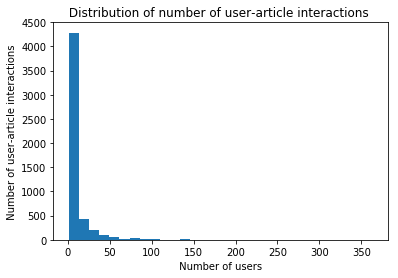

In [9]:
# Check in a histogram the distribution of users-articles interactions

plt.hist(art_user_interactions, bins=30)
plt.title(" Distribution of number of user-article interactions  ")
plt.xlabel(" Number of users ")
plt.ylabel(" Number of user-article interactions ")
#plt.show()

In [10]:
# Check some statistics about the distribution of the number of user-article interactions
art_user_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [11]:
# Fill in the median and maximum number of user_article interactios below

median_val = art_user_interactions.median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = art_user_interactions.max() # The maximum number of user-article interactions by any 1 user is 364.

In [12]:
# Show the median of the number of user-article interactions
print(median_val)

3.0


In [13]:
# Show the max value of the number of user-article interactions
print(max_views_by_user)

364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [14]:
# Find and explore duplicate articles --> 
# Check the number of duplicated rows in the dataset df_content

df_content.duplicated().sum()

0

In [15]:
# Check the number of duplicated in the column "article_id"
df_content["article_id"].duplicated().sum()

5

In [16]:
# Remove any rows that have the same article_id - only keep the first

df_content.drop_duplicates(subset="article_id", keep="first", inplace=True)

In [17]:
# Check again the number of duplicated in the column "article_id" --> It should be 0 now
df_content["article_id"].duplicated().sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [18]:
# a) The number of unique articles that have an interaction with a user.

# The user-article interactions are defined in the df dataset

# First of all, let's remember the number of unique articles in the df dataset

#df["article_id"].nunique()

df.article_id.nunique()

714

In [19]:
# Let's check the number of "NaN" in the email column of the df dataset (column that defines the different users):
df.email.isnull().sum()

17

In [20]:
# In order to ensure that the number of unique articles that interact with a non-NaN email (user),
# condition of df["email"] != NaN will be imposed
df[~pd.isna(df["email"])].article_id.nunique()

714

In [21]:
# b) The number of unique articles in the dataset (whether they have any interactions or not).
# All the articles can be found in the df_content dataset
df_content.article_id.nunique()

1051

In [22]:
# c) The number of unique users in the dataset. (excluding null values)
# Users (defined by an "encripted" email address) appear in the df dataset, specifically in the column "email"
df.email.nunique()

5148

In [23]:
# d) The number of user-article interactions in the dataset 
# the number of rows of the df dataset represents the number of user-article interactiond in the dataset
df.shape[0]

45993

In [24]:
unique_articles = df[~pd.isna(df["email"])].article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [25]:
# Show the number of unique articles that have at least one interaction
print(unique_articles)

714


In [26]:
# Show the number of unique articles on the IBM platform
print(total_articles)

1051


In [27]:
# Show the number of unique users
print(unique_users)

5148


In [28]:
# Show the number of user-article interactions
print(user_article_interactions)

45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [29]:
most_viewed_article_id = str(df['article_id'].value_counts().idxmax()) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().max()# The most viewed article in the dataset was viewed how many times?

In [30]:
# Show the most viewed article
print(most_viewed_article_id)

1429.0


In [31]:
# Show the number of views of the most viewed article
print(max_views)

937


In [32]:
df['title'].value_counts().keys()[0:7].tolist()

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization']

In [33]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [34]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [35]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    top_articles = df['title'].value_counts().keys()[0:n].tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().keys()[0:n].tolist()
 
    return top_articles # Return the top article ids

In [36]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [37]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [38]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # make a copy of the original dataset
    df_copy = df.copy()
    
    # drop duplicate rows in the original 
    df_copy.drop_duplicates(inplace=True)
    
    #drop rows with emptu user_id
    df_copy.dropna(subset=["user_id"], inplace=True)
    
    # create a pivot table  with "user_id" as index and "article_id" as columns
    df_pivot = df_copy.pivot(index = "user_id", columns = "article_id")
    
    # complete with 0 for no user-article matches
    df_pivot.replace(np.nan, 0, inplace=True)
    
    # complete with 0 for no user-article matches
    df_pivot = df_pivot.apply(pd.to_numeric, errors='coerce').fillna(1)
    
    # convert all the components to integer
    df_pivot = df_pivot.astype(int)
    
    user_item = df_pivot
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [39]:
user_item.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1               0      0      0      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
3               0      0      0      0      0      1      0      0      0   
4               0      0      0      0      0      0      0      0      0   
5               0      0      0      0      0      0      0      0      0   

                   ...                                                     \
article_id 18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                      
1               0  ...        0      0      1      0      1      0      0   
2               0  ...        0      0      0      0      0      0      0   
3               0  ...        0      0      1      0      0      0      0   
4               0  ...        0      0      0      0      0      0      0   
5               0  ...        0      0      0      0      0      0      0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1               0      0      0  
2               0      0      0  
3               0      0      0  
4               0      0      0  
5               0      0      0  

[5 rows x 714 columns]

In [40]:
user_item.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=5149)

In [41]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [42]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    
    # 1.1 calculate similarity
    similarity = []
    
    user_item_copy = user_item.copy()
    
    for i in user_item_copy.index:
        similarity.append(np.dot(user_item_copy.loc[i,:],user_item_copy.loc[user_id,:]))

    # 1.2 add a new similarity column
    user_item_copy["Similarity"] = similarity

    # sort by similarity
    user_item_copy.sort_values(by ='Similarity', ascending=False, inplace=True)   

    # create list of just the ids
    most_similar_users = user_item_copy.index.tolist()
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [43]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [44]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    for i in range(len(article_ids)):
        article_ids[i]=float(article_ids[i])
    
    article_names = []
    
    for i in range(len(article_ids)):
        first_index_valid = df[df.article_id == article_ids[i]].first_valid_index()
        article_names.append(df.loc[first_index_valid,"title"])
        
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    article_ids = []
    
    for col in user_item:
        if (user_item.loc[(user_id),col] == 1):  ###### CAMBIAR LO DE user_id-1 cuando se pueda dummy
            article_ids.append(col[1])

    article_names = get_article_names(article_ids)
    
    for i in range(len(article_ids)):
        article_ids[i]=str(article_ids[i])
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # get the list of articles (article_id and title) that have been seen by the user defined by user_id
    article_seen_user = get_user_articles(user_id)
    
    # get the list of most similar users to user_id
    similar_users = find_similar_users(user_id)  
    
    # for the first in the list of most similar users, find the articles that have been seen by this closest user and not by
    # user_id. Find the 10 first. If there are less than 10, then go to the second most similar user, and try to complete.
    # If not, go to the third user. And so on.
    

    recs = []
    count = 0
    for i in range(len(similar_users)):
        article_similar_user = get_user_articles(similar_users[i])[0]
        for j in range(len(article_similar_user)):
            if ((article_similar_user[j] not in article_seen_user) & (article_similar_user[j] not in recs)):
                recs.append(article_similar_user[j])
            if (len(recs)>=10):
                break
        if (len(recs)>=10):
            break

    
    return recs # return your recommendations for this user_id    

In [45]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['deep learning with tensorflow course by big data university',
 'tensorflow quick tips',
 'sector correlations shiny app',
 'time series prediction using recurrent neural networks (lstms)',
 'introduction to market basket analysis in\xa0python',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'introducing ibm watson studio ',
 'python for loops explained (python for data science basics #5)',
 'new shiny cheat sheet and video tutorial',
 'tidyverse practice: mapping large european cities']

In [46]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [47]:
float(get_user_articles(1)[0][-1])

1439.0

In [48]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # work with a copy of user_item
    user_item_copy = user_item.copy()
    
    # 1.1 calculate similarity
    similarity = []
    
    for i in user_item_copy.index:
        similarity.append(np.dot(user_item_copy.loc[i,:],user_item_copy.loc[user_id,:]))
    
    # 1.2 add a new similarity column
    user_item_copy["similarity"] = similarity
    
    # keep only the columns of interest
    user_item_copy=user_item_copy[['similarity']]    
    
    # calculate the number of interactions per user
    number_interactions = []
    
    for i in range(len(user_item_copy.index)):
        #print(user_item_copy.loc[i,"Similar_users"])
        number_interactions.append(df["user_id"][df["user_id"]==user_item_copy.index[i]].count())
    
    # create a new column for the number of interactions of each user
    user_item_copy["num_interactions"] = number_interactions
    
    # sort by similarity 
    # user_item_copy.sort_values(['a', 'b'], ascending=False, inplace=True) 
    user_item_copy.sort_values(['similarity', 'num_interactions'], ascending=[False, False], inplace=True)
    
    # drop the row corresponding to the own user's id
    user_item_copy.drop(user_item_copy.index[0],inplace=True)
    
    # create list of just the ids
    neighbors_id = user_item_copy.index.tolist()
    
    # add a new neighbors_id column
    user_item_copy["neighbors_id"] = neighbors_id
    
    # remove multi-level column name
    user_item_copy.columns=["similarity", 'num_interactions', "neighbors_id"]
    
    # rearrange the order of columns
    user_item_copy = user_item_copy.reindex(columns=["neighbors_id", "similarity", 'num_interactions'])
    
    # get final output
    neighbors_df = user_item_copy
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # get the list of articles (article_id and title) that have been seen by the user defined by user_id
    article_seen_user = get_user_articles(user_id)
    
    # get the list of most similar users to user_id, already sortered by 1) similarity with user_id, 2) number of total interactions
    similar_users = get_top_sorted_users(user_id).loc[:,"neighbors_id"].tolist()
    
    
    # for the first in the list of most similar users, find the articles that have been seen by this closest user and not by
    # user_id. Find the 10 first. If there are less than 10, then go to the second most similar user, and try to complete.
    # If not, go to the third user. And so on.
    

    recs = []
    count = 0
    
    for i in range(len(similar_users)): # go through the list of users, already sorted
        article_similar_user = get_user_articles(similar_users[i])[0] # provides a list of the articles_id seen by the user
        article_similar_user = [int(float(i)) for i in article_similar_user] 
        similar_user_max_article_id = int(float(get_user_articles(similar_users[i])[0][-1])) # obtain the higher article_id
        top_article_ids = get_top_article_ids(similar_user_max_article_id) # rearrange 
        #article_similar_user_sorted = sorted(article_similar_user, key = top_article_ids.index)
        article_similar_user_sorted = [ele for ele in top_article_ids if ele in article_similar_user]
        for j in range(len(article_similar_user_sorted)):
            if ((article_similar_user_sorted[j] not in article_seen_user) & (article_similar_user_sorted[j] not in recs)):
                recs.append(article_similar_user_sorted[j])
            if (len(recs)>=10):
                break
        if (len(recs)>=10):
            break
            
    rec_names = get_article_names(recs) 
    
    return recs, rec_names

In [49]:
user_user_recs_part2(1, 10)

([1429.0,
  1431.0,
  1427.0,
  1293.0,
  1170.0,
  1436.0,
  43.0,
  1185.0,
  1368.0,
  1305.0],
 ['use deep learning for image classification',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'welcome to pixiedust',
  'deep learning with tensorflow course by big data university',
  'classify tumors with machine learning',
  'putting a human face on machine learning',
  'gosales transactions for naive bayes model'])

In [50]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


In [51]:
user_user_recs_part2(88)[1]

['insights from new york car accident reports',
 'healthcare python streaming application demo',
 'gosales transactions for logistic regression model',
 'the nurse assignment problem',
 'classify tumors with machine learning',
 'analyze accident reports on amazon emr spark',
 'putting a human face on machine learning',
 'gosales transactions for naive bayes model',
 'ml optimization using cognitive assistant',
 'apache spark lab, part 3: machine learning']

In [52]:
get_article_names(user_user_recs(88, 10)) # Return 10 recommendations for user 1

['using machine learning to predict parking difficulty',
 'the 3 kinds of context: machine learning and the art of the frame',
 'how to scale your analytics using r',
 'tensorflow quick tips',
 'a dynamic duo – inside machine learning – medium',
 'statistics for hackers',
 'sector correlations shiny app',
 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics',
 'this week in data science (march 7, 2017)',
 'pixiedust 1.0 is here! – ibm watson data lab']

In [53]:
get_top_article_ids(25)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0,
 1436.0,
 1271.0,
 1398.0,
 43.0,
 1351.0,
 1393.0,
 1185.0,
 1160.0,
 1354.0,
 1368.0,
 1305.0,
 1338.0,
 1336.0,
 1165.0,
 1172.0]

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [54]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).index[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).index[9] # Find the 10th most similar user to user 131

In [55]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

As no information about a new user is available, any content-based recommendation method shall be ruled out. Instead, a rank-based method seems to be a good option to avoid the so-called "cold start problem". Therefore, the get_top_article function seems the best pick.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [56]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id) for id in get_top_article_ids(10)] 



In [57]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [58]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [59]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [60]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [61]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [62]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [63]:
print("Size of the U matrix is: ")
print(u.shape)

Size of the U matrix is: 
(5149, 5149)


In [64]:
print("Size of the S matrix is: ")
print(s.shape)

Size of the S matrix is: 
(714,)


In [65]:
print("Size of the Vt matrix is: ")
print(vt.shape)

Size of the Vt matrix is: 
(714, 714)


There are some difference between this case study and what we have learned in the lessons. First, the input matrix in the lessons contained the ratings each user provided to each entity (movies in this case) they had seen, whereas the input matrix in this project contains only 1s and 0s, depending on whether each user (rows) has interacted with each article (columns) or not. Another difference is the presence of NaN in the lesson, something that happens when a user has not seen the movie and cannot rate it. As in the project, the 1/0 matrix contains no NaN, there is no need to use FunkSVD (Single Value Decomposition). Standard SVD is applicable here. Another spotted difference is that the number of latent factors used in the lesson was small, but in this project it can be up to the number of  unique articles (714)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

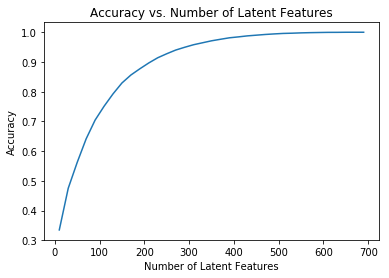

In [66]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [67]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    # create a user_item matrix based on the train set
    user_item_train = create_user_item_matrix(df_train)

    # create a user_item matrix based on the test set
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [68]:
# Check shape of user_item_train
user_item_train.shape

(4487, 714)

In [69]:
# Check shape of user_item_test
user_item_test.shape

(682, 574)

In [70]:
# a) How many users can we make predictions for in the test set?
# In order to check that, we have to check how many users are in both user_item_train and in user_item_test

len(np.intersect1d(user_item_test.index, user_item_train.index))

20

In [71]:
# b) How many users in the test set are we not able to make predictions for because of the cold start problem:
# It is understood that when we talk about "users we cannot make predictions for" we have to take into account users
# that are among the user_item_test. As the cold start problem is typical for user or products we don't have recommendations
# for yet, in this case they should be users inside the user_item_test that are not included in user_item_train

len(set(user_item_test.index)-set(user_item_train.index))

## --> For these users, knowledge-based and/or content-based recommendations shall be used instead

662

In [72]:
# c) How many movies can we make predictions for in the test set?
# we have to check how many items are included in (movies, articles, whatever) are included in both user_item_train and in
# user_item_test

len(np.intersect1d(user_item_test.columns, user_item_train.columns))

574

In [73]:
# d) How many movies in the test set are we not able to make predictions for because of the cold start problem?
# We have to check which columns that are among the user_item_test columns are not among the user_item_test columns

len(set(user_item_test.columns)-set(user_item_train.columns))

0

In [74]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [75]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [76]:
print("Size of the U_train matrix is: ")
print(u_train.shape)

Size of the U_train matrix is: 
(4487, 4487)


In [77]:
print("Size of the S_train matrix is: ")
print(s_train.shape)

Size of the S_train matrix is: 
(714,)


In [78]:
print("Size of the Vt matrix is: ")
print(vt_train.shape)

Size of the Vt matrix is: 
(714, 714)


In [79]:
user_item_test.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
2917            0      0      0      0      0      0      0      0      0   
3024            0      0      0      0      0      1      0      0      0   
3093            0      0      0      0      0      0      0      0      0   
3193            0      0      0      0      0      0      0      0      0   
3527            0      0      0      0      0      0      0      0      0   

                   ...                                                     \
article_id 18.0    ...   1432.0 1433.0 1434.0 1435.0 1436.0 1437.0 1439.0   
user_id            ...                                                      
2917            0  ...        0      0      0      0      0      0      0   
3024            0  ...        0      0      0      0      0      0      0   
3093            0  ...        0      0      0      0      1      0      0   
3193            0  ...        0      0      0      0      0      0      0   
3527            0  ...        0      0      0      0      0      0      0   

                                 
article_id 1440.0 1441.0 1443.0  
user_id                          
2917            0      0      0  
3024            0      0      0  
3093            0      0      0  
3193            0      0      0  
3527            0      0      0  

[5 rows x 574 columns]

In [80]:
# First, we have to find out the rows (user_ids) that are found in both train and test sets
train_test_idx = user_item_train.index.isin(test_idx)
train_test_idx

array([False, False, False, ..., False, False,  True], dtype=bool)

In [81]:
# obtain the rows that are in both train and test, and typecast the resulting np.array to a list
common_idx = np.intersect1d(user_item_test.index, user_item_train.index)
common_idx.tolist();

In [82]:
# obtain the columns that are in both train and test sets, and typecast the resulting np.array to a list
common_arts = np.intersect1d(user_item_test.title.columns, user_item_train.title.columns)
common_arts.tolist();

In [83]:
# Remove level fron user_item_train columns
user_item_train.columns = user_item_train.columns.droplevel()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


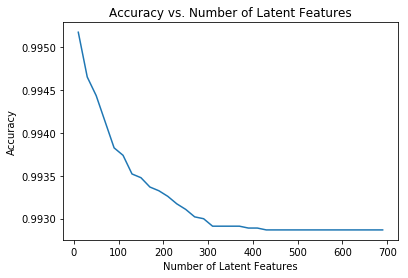

In [84]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # Convert u_train_new to pd.DataFrame and set the index to user_item_train.index
    u_train_new = pd.DataFrame(u_train_new)
    u_train_new.set_index(user_item_train.index)
    
    # Convert vt_train_new to pd.DataFrame and set the columns to user_item_train.columns
    vt_train_new = pd.DataFrame(vt_train_new)
    vt_train_new.columns = user_item_train.columns
    
    # S matrix, corresponding to the latent factos, will be the same for both train and test sets
    s_test_new =   s_train_new
    
    # U matrix of the test set will be obtained as the U matrix of the train set, sliced by the indexes in common
    u_test_new =   u_train_new.loc[common_idx,:]
    
    # Vt matriz of the test set will be obtained as the U matrix of the train set, sliced by the columns in common
    vt_test_new =  vt_train_new.loc[:,common_arts]

    # take dot product
    user_test_item_est = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))
    
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test.loc[common_idx,:], user_test_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The overall accuracy of the model is high. Dependency on the number of latent factors is limited, however it can be observed how the accuracy shows a slight decrease when the number of latent factos increases, until reaching a horizontal asymptote whose value is still over 0.992. Instead of the number of latent factors, a good proposal to increase (even more) the accuracy of the model would be selecting different train & test subsets.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [85]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0